# 75.26 Modelos y Simulación

# Trabajo Práctico 2

## Grupo 2

### Alumnos:

- Duzac, Emilia
- Belletti, Gabriel Ignacio
- Vazquez, Nicolás Alberto
- Cohen, Martín

### Generador de números aleatorios elegido: [MIXMAX](http://arxiv.org/pdf/1403.5355)

## Ejercicio 2

### Método asignado en la planilla de grupos: SIMPY

Una entidad financiera está analizando cambiar uno de sus cajeros automáticos por uno con la funcionalidad de reciclador
de billetes (si un cliente realiza un depósito de efectivo, ese efectivo estará disponible para que lo pueda retirar otro cliente).
El cajero automático actual, que se quiere reemplazar, es de tipo estándar. No recicla los billetes, sino que posee dos
compartimentos, uno con dinero para entregar y otro donde guarda el dinero que se deposita.
Esto presenta los siguientes problemas:

- Si no tiene más efectivo para entregar en el compartimento de retiro de dinero, no entrega efectivo, aunque tenga en el compartimento de depósitos.
- Si el compartimento que recibe los depósitos se completa, no puede recibir más.

La entidad conoce que con el cajero actual el 25% de los clientes se retiraba sin poder extraer dinero, y sólo acepta cambiarlo si este porcentaje disminuye.

Por simplicidad suponer que el cajero sólo expende billetes de una denominación, tiene una capacidad máxima de 2000
billetes, y comienza el día con su carga completa.

En el relevamiento que realizó la entidad diferenció a sus clientes en dos grupos:

- Grupo 1: Sólo retiran efectivo, y corresponden al 75% de los clientes que arriban. El tiempo que utilizan el cajero se puede modelar con una distribución exponencial de media 90 segundos. Cada cliente de este grupo extrae una cantidad de billetes que sigue una distribución uniforme $[3,50]$.
- Grupo 2: Sólo realizan depósitos, son el 25% de los clientes totales. Utilizan el cajero un tiempo que sigue una distribución exponencial de media 5 minutos ($5min = 300seg$). Cada cliente de este grupo deposita una cantidad de billetes que se puede modelar utilizando una distribución uniforme $[10,110]$.

El área a cargo de modelar el problema, propuso un tiempo de arribo de clientes que sigue una distribución de
probabilidades exponencial con media = 180 seg.

### Se pide:

1. Simular, utilizando el generador de números al azar desarrollado en el tp 1, 100 días completos de 24 hrs,
independientes (utilizando distintas semillas en el generador).
2. Graficar la cantidad media de billetes disponibles en el cajero luego de cada transacción.
3. Graficar la distribución de los tiempos que los clientes demoran en el sistema (espera + utilización del cajero).
4. Calcular el tiempo medio y el desvío estándar del tiempo que los clientes demoran en el Sistema.
5. Proponer otras frecuencias de arribos de clientes y comparar los resultados obtenidos.

### Consideraciones/Suposiciones

- El cajero sólo admite billetes de una denominación por lo que se hablará de cantidad de billetes en lugar del monto representado por estos.
- El cliente utiliza el tiempo total respectivo, de forma independiente de si falla o tiene éxito la operación a realizar.

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import simpy
import threading
# el csv se importa solo para la extraccion e importacion de los resultados con otro grupo
import csv

In [2]:
from MixMax import MixmaxRNG

### Constantes

In [3]:
# cantidad de dias simulados
TOTAL_SIMULATIONS = 100
# tiempo total del dia para recarga de efectivo (cada dia se recarga el efectivo) 3600 * 24 = 86 400
DAY_TIME = 86400.0
# arribo de clientes 1 cliente cada 180s (de media) equivale a 1/180 clientes/s
ARRIVAL_CLIENT = 1.0/180.0

# GRUPO 1 retiro de efectivo
# proporcion de grupo 1
PROPORTION_GROUP_1 = 0.75
# intervalo de valores posibles de extraccion (cantidad de billetes que se extraen)
EXTRACTION_INTERVAL = (3, 50)
# tiempo de uso del cajero
TIME_LAMBDA_GROUP_1 = 1/90

# GRUPO 2 ingreso de efectivo
# intervalo de valores posibles de deposito (cantidad de billetes que se depositan)
DEPOSIT_INTERVAL = (10, 110)
# tiempo de uso del cajero
TIME_LAMBDA_GROUP_2 = 1/300

# capacidad maxima de billetes del cajero
MAX_AMOUNT_OF_BILLS = 2000

# semillas
# semilla de arribos
SEED_ARRIVALS = 1235
# semilla base de clientes
SEED_CLIENT_TIPE = 785

# cantidad de cajeros disponibles
NUMBER_OF_CASHIERS = 1

# proporcion de extracciones fallidas antes
EXTRACTION_FAILURE_OLD = 0.25

### Código

In [4]:
class DailyCustomerEvent:
    def __init__(self):
        self.time_delay = []
        self.n_bills = []
        self.n_extraction_failure = 0.0
        self.extraction_attempts = 0.0
        self.time_delay_extraction = []
        self.time_delay_deposit = []

    def extraction(self, rest, time, is_failure):
        self.extraction_attempts += 1.0
        if is_failure:
            self.n_extraction_failure += 1.0
        self.time_delay.append(time)
        self.n_bills.append(rest)
        self.time_delay_extraction.append(time)

    def income(self, rest, time):
        self.time_delay.append(time)
        self.n_bills.append(rest)
        self.time_delay_deposit.append(time)

    def median_bills(self):
        # caso en donde nadie hizo transaccion el cajero esta completo
        if len(self.n_bills) == 0:
            return 2000.0
        return np.median(self.n_bills)

    def time_median_and_std(self):
        # caso en donde nadie hizo transaccion
        if len(self.time_delay) == 0:
            return 0, 0
        median = np.median(self.time_delay)
        std = np.std(self.time_delay)
        return median, std

    def time_of_extraction_median_and_std(self):
        # caso en donde nadie hizo transaccion
        if len(self.time_delay_extraction) == 0:
            return 0, 0
        median = np.median(self.time_delay_extraction)
        std = np.std(self.time_delay_extraction)
        return median, std

    def time_deposit_median_and_std(self):
        # caso en donde nadie hizo transaccion
        if len(self.time_delay_deposit) == 0:
            return 0, 0
        median = np.median(self.time_delay_deposit)
        std = np.std(self.time_delay_deposit)
        return median, std

    """Returns the number of extraction failures divided by the number of extractions.
    Case where there have been no extractions returns zero."""
    def extraction_failure(self):
        if self.extraction_attempts == 0 or self.n_extraction_failure == 0:
            return 0
        extraction_failure_proportion = self.n_extraction_failure / self.extraction_attempts
        return extraction_failure_proportion


In [5]:
def exponencial(val_p, value_lambda):
    return -(np.log(1 - val_p)) / value_lambda

"""returns a list with the time of arrivals (not accumulated), up to the given maximum time."""
def generate_arrivals(seed, total_seconds, value_lambda):
    result = []
    total = 0.0
    # generador de numeros aleatorios
    random = MixmaxRNG(seed)
    while True:
        # nuevo arribo en segundos
        exp = exponencial(random.generate_number(), value_lambda)
        # tiempo acumulado de arribo
        total += exp
        # caso donde se pasa del tiempo maximo corta el bucle
        if total > total_seconds:
            break
        # se agrega el tiempo entre arribos (NO acumulado)
        result.append(exp)
    return result

In [6]:
"""returns true if, according to the given value, it belongs to group 1."""
def is_group_1(p_val):
    return p_val < PROPORTION_GROUP_1

"""client withdrawing money."""
def client_group_1(env, cashier, random, res_cashier, arrival_time, statistics, debug):
    # generan el valor de la cantidad de billetes que usaran (extraer)
    extraction = int(round(random.generate_number(interval=EXTRACTION_INTERVAL), 0))
    # tiempo que necesito para realizar la operacion
    time = exponencial(random.generate_number(), TIME_LAMBDA_GROUP_1)
    with res_cashier.request() as req:
        yield req
        if debug:
            print(f'{env.now:7.3f} s: Extraction of {extraction} begins.')
        # caso donde hay dinero para extraer
        permission = cashier.level >= extraction
        if permission:
            cashier.get(extraction)
        # consume tiempo manteniendo el recurso para si
        yield env.timeout(delay=time)
        if debug:
            print(f'{env.now:7.3f} s: Correct extraction {permission}.', )
        statistics.extraction(cashier.level, env.now - arrival_time, not permission)
    return

"""customer depositing money."""
def client_group_2(env, cashier, random, res_cashier, arrival_time, statistics, debug):
    # generan el valor de la cantidad de billetes que usaran (depositar)
    deposit = int(round(random.generate_number(interval=DEPOSIT_INTERVAL), 0))
    # tiempo que necesito para realizar la operacion
    time = exponencial(random.generate_number(), TIME_LAMBDA_GROUP_2)
    with res_cashier.request() as req:
        yield req
        if debug:
            print(f'{env.now:7.3f} s: Deposit of {deposit} begins.')
        # caso donde hay espacio para depositar dinero
        permission = cashier.level + deposit <= MAX_AMOUNT_OF_BILLS
        if permission:
            cashier.put(deposit)
        # consume tiempo manteniendo el recurso para si
        yield env.timeout(delay=time)
        if debug:
            print(f'{env.now:7.3f} s: Correct deposit {permission}.')
        statistics.income(cashier.level, env.now - arrival_time)
    return

""""""
def client(env, list_arrivals_of_clients, seed, cashier, res_cashier, statistics, debug):
    random = MixmaxRNG(seed)
    # para cada arribo se clasifica en los dos grupos
    if debug:
        print(f'{env.now:7.3f} s: Clients arrivals begins.')
    for delay in list_arrivals_of_clients:
        # pasa un tiempo antes del evento
        yield env.timeout(delay=delay)
        arrival_time = env.now
        if debug:
            print(f'{arrival_time:7.3f} s: Arrived new client.')
        # se toma un numero al azar (uniforme) para saber en que grupo caen
        p_val = random.generate_number()
        if is_group_1(p_val):
            env.process(client_group_1(env, cashier, random, res_cashier, arrival_time, statistics, debug))
        else:
            env.process(client_group_2(env, cashier, random, res_cashier, arrival_time, statistics, debug))
    if debug:
        print(f'{env.now:7.3f} s: Clients arrivals finish.')

In [7]:
def daily_simulation(seed_arrivals=SEED_ARRIVALS, seed_clients=SEED_CLIENT_TIPE, arrival_client=ARRIVAL_CLIENT, total_time=DAY_TIME, debug=False):
    # estadisticas de la simulacion
    statistics = DailyCustomerEvent()
    # creacion del entorno simpy
    env = simpy.Environment()
    # creacion de recurso de cajero (contiene billetes) (inicia con la maxima cantidad de billetes)
    cashier = simpy.Container(env, MAX_AMOUNT_OF_BILLS, init=MAX_AMOUNT_OF_BILLS)
    # cantidad de recurso cajero disponible
    res_cashier = simpy.Resource(env, NUMBER_OF_CASHIERS)
    # llegada de clientes
    arrivals_of_clients = generate_arrivals(seed_arrivals, total_time, arrival_client)
    # procesado de clientes
    proc = env.process(client(env, arrivals_of_clients, seed_clients, cashier, res_cashier, statistics, debug))
    env.run(until=proc)
    return statistics

stats = daily_simulation(total_time=600.0, debug=True, arrival_client=1/60)
print("Median n bills: ", stats.median_bills(),
      "\nMedian;std of all time: ", stats.time_median_and_std(),
      "\nMedian;std of time (only deposits): ", stats.time_deposit_median_and_std(),
      "\nMedian;std of time (only extractions): ", stats.time_of_extraction_median_and_std(),
      "\nFailure extraction proportion: ", stats.extraction_failure())

  0.000 s: Clients arrivals begins.
 40.164 s: Arrived new client.
 40.164 s: Extraction of 48 begins.
 65.897 s: Arrived new client.
103.944 s: Arrived new client.
123.355 s: Correct extraction True.
123.355 s: Extraction of 28 begins.
175.393 s: Arrived new client.
192.105 s: Correct extraction True.
192.105 s: Extraction of 7 begins.
220.546 s: Correct extraction True.
220.546 s: Extraction of 8 begins.
303.350 s: Arrived new client.
307.565 s: Arrived new client.
349.824 s: Arrived new client.
382.132 s: Arrived new client.
411.433 s: Correct extraction True.
411.433 s: Extraction of 46 begins.
427.199 s: Arrived new client.
495.180 s: Arrived new client.
499.079 s: Arrived new client.
499.079 s: Clients arrivals finish.
Median n bills:  1920.5 
Median;std of all time:  (121.40492082637331, 57.418650120008756) 
Median;std of time (only deposits):  (0, 0) 
Median;std of time (only extractions):  (121.40492082637331, 57.418650120008756) 
Failure extraction proportion:  0


In [8]:
def wrapper_daily_simulation(vec, pos, seed_arrivals=SEED_ARRIVALS, seed_clients=SEED_CLIENT_TIPE, arrival_client=ARRIVAL_CLIENT, total_time=DAY_TIME, debug=False):
    vec[pos] = daily_simulation(seed_arrivals=seed_arrivals, seed_clients=seed_clients, arrival_client=arrival_client, total_time=total_time, debug=debug)

def simulaction(total_simulations=TOTAL_SIMULATIONS, seed_base_arrivals=SEED_ARRIVALS, seed_base_clients=SEED_CLIENT_TIPE, arrival_client=ARRIVAL_CLIENT, total_time=DAY_TIME, debug=False):
    # lista de estadisticas de resultados
    result_of_simulations = [None] * total_simulations
    # aplico un modelo fork-join donde separo cada simulacion independiente en un hilo diferente.
    threads = [None] * total_simulations
    total_range = range(total_simulations)
    for n_simulation in total_range:
        # actualizo la semilla de arribos
        seed_arrivals = seed_base_arrivals + n_simulation
        # actualizo la semilla de clientes
        seed_clients = seed_base_clients + n_simulation
        simulation_lambda = lambda vec, pos: wrapper_daily_simulation(vec, pos, seed_arrivals=seed_arrivals, seed_clients=seed_clients, arrival_client=arrival_client, total_time=total_time, debug=debug)
        threads[n_simulation] = threading.Thread(target=simulation_lambda, args=(result_of_simulations, n_simulation))
        threads[n_simulation].start()
    for n_simulation in total_range:
        threads[n_simulation].join()
    return result_of_simulations

stats_all = simulaction(total_time=180.0, debug=True, arrival_client=1/30, total_simulations=10)
print("number of results equal to number of simulations: ", len(stats_all)==10,
      "\nMedian n bills: ", list(map(lambda x: x is None, stats_all)),
      "\nMedian n bills: ", list(map(lambda x: x.median_bills(), stats_all)),
      "\nFailure extraction proportion: ", list(map(lambda x: x.extraction_failure(), stats_all)))

  0.000 s: Clients arrivals begins.
 20.082 s: Arrived new client.
 20.082 s: Extraction of 48 begins.
 32.948 s: Arrived new client.
 51.972 s: Arrived new client.
  0.000 s: Clients arrivals begins.
 37.532 s: Arrived new client.
  0.000 s: Clients arrivals begins.
 37.532 s: Arrived new client.
 87.696 s: Arrived new client.
 37.532 s: Extraction of 45 begins.
 41.963 s: Arrived new client.
 37.532 s: Extraction of 43 begins.
 39.887 s: Arrived new client.
  0.000 s: Clients arrivals begins.
 84.212 s: Arrived new client.
103.274 s: Correct extraction True.
103.274 s: Extraction of 28 begins.
151.675 s: Arrived new client.
107.750 s: Arrived new client.
  0.000 s: Clients arrivals begins.
 84.212 s: Arrived new client.
  0.000 s: Clients arrivals begins.
 84.212 s: Arrived new client.
 84.212 s: Extraction of 30 begins.
132.832 s: Arrived new client.
153.783 s: Arrived new client.
 40.962 s: Arrived new client.
  0.000 s: Clients arrivals begins.
 37.532 s: Arrived new client.
 84.2

#### Graficadores

In [9]:
def plot_median_bills(all_simu):
    values = list(map(lambda x: x.median_bills(), all_simu))
    plt.hist(values)
    plt.title('Average amount of bills.')
    plt.show()

In [10]:
def plot_delay_times(all_simu):
    # Separo los 6 graficos de tiempo de espera
    # Cada fila es un tiempo diferente, cada columna es media o desviacion
    fig, axs = plt.subplots(nrows=3, ncols=2)
    # delay = tiempo de espera + tiempo de uso
    # all = extration + deposit

    # all
    # mediana
    values_median_all = list(map(lambda x: x.time_median_and_std()[0], all_simu))
    axs[0, 0].hist(values_median_all)
    axs[0, 0].set_title('mean delay times (all)')
    # desvio
    values_std_all = list(map(lambda x: x.time_median_and_std()[1], all_simu))
    axs[0, 1].hist(values_std_all)
    axs[0, 1].set_title('std delay times (all)')

    # extraciones
    # mediana
    values_median_extract = list(map(lambda x: x.time_of_extraction_median_and_std()[0], all_simu))
    axs[1, 0].hist(values_median_extract)
    axs[1, 0].set_title('mean delay times (only extrantions)')
    # desvio
    values_std_extract = list(map(lambda x: x.time_of_extraction_median_and_std()[1], all_simu))
    axs[1, 1].hist(values_std_extract)
    axs[1, 1].set_title('std delay times (only extrantions)')
    fig.tight_layout()

    # Depositos
    # mediana
    values_median_deposit = list(map(lambda x: x.time_deposit_median_and_std()[0], all_simu))
    axs[2, 0].hist(values_median_deposit)
    axs[2, 0].set_title('mean delay times (only deposit)')
    # desvio
    values_std_deposit = list(map(lambda x: x.time_deposit_median_and_std()[1], all_simu))
    axs[2, 1].hist(values_std_deposit)
    axs[2, 1].set_title('std delay times (only deposit)')
    fig.tight_layout()
    plt.show()

In [27]:
""""""
def proportion_of_successful_extractions(all_simu, max_proportion_failure=EXTRACTION_FAILURE_OLD):
    # comparo si la cantidad de fallas es menor a la "aceptada" para cambiar el cajero
    l = list(map(lambda x: x.extraction_failure()<max_proportion_failure, all_simu))
    ok = 0.0
    for f in l:
        if f:
            ok += 1.0
    # retorno la proporcion que logra cumplir con la condicion para ser "aceptada"
    return ok / len(l)

def extraction_failure_info(all_simu):
    l = list(map(lambda x: x.extraction_failure(), all_simu))
    median = np.median(l)
    std = np.std(l)
    print("Max = ", max(l), "Min = ", min(l), "Median = ", median, "std = ", std)
    return max(l), min(l), median, std

#### Simulación de arribos 1/180 (base del problema)

In [17]:
# corro la simulacion completa
complete_simulation = simulaction()
print(len(complete_simulation) == TOTAL_SIMULATIONS)

True


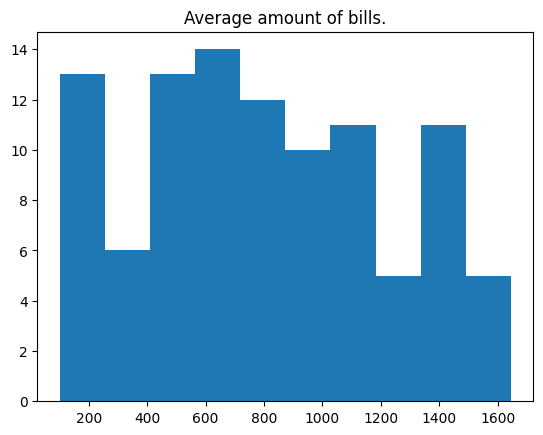

In [18]:
plot_median_bills(complete_simulation)

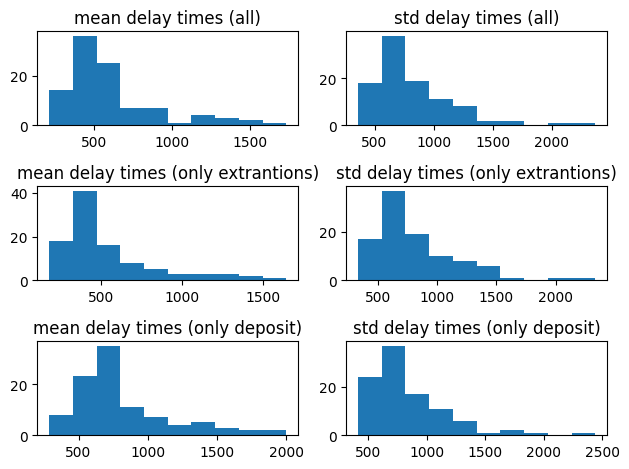

In [19]:
plot_delay_times(complete_simulation)

In [31]:
print("Fallas de extraccion:")
extraction_failure_info(complete_simulation)
print("Proporcion de simulaciones donde se acepta: ", proportion_of_successful_extractions(complete_simulation))

Fallas de extraccion:
Max =  0.22597402597402597 Min =  0 Median =  0.055952380952380955 std =  0.05977287884240527
Proporcion de simulaciones donde se acepta:  1.0


#### Simulación de arribos 1/90

In [32]:
# corro la simulacion completa con otra cantidad de arribos
# tomo el doble de arribos de clientes
complete_simulation_2 = simulaction(arrival_client=ARRIVAL_CLIENT*2)
print(len(complete_simulation_2) == TOTAL_SIMULATIONS)

True


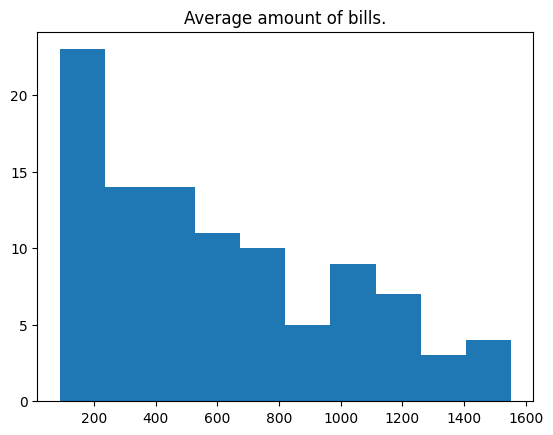

In [33]:
plot_median_bills(complete_simulation_2)

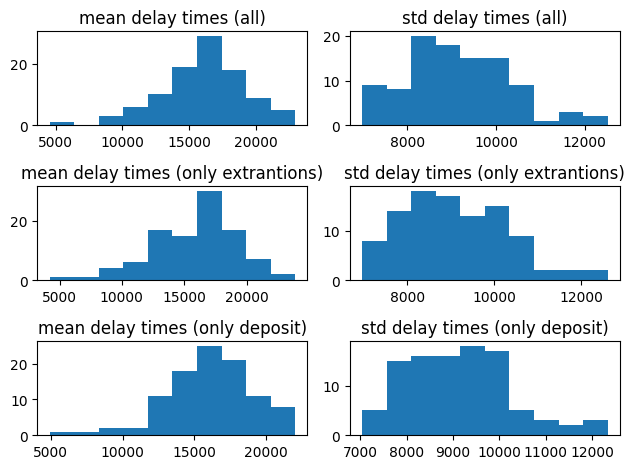

In [34]:
plot_delay_times(complete_simulation_2)

In [35]:
print("Fallas de extraccion:")
extraction_failure_info(complete_simulation_2)
print("Proporcion de simulaciones donde se acepta: ", proportion_of_successful_extractions(complete_simulation_2))

Fallas de extraccion:
Max =  0.24789915966386555 Min =  0 Median =  0.08804000755985716 std =  0.06229437189396389
Proporcion de simulaciones donde se acepta:  1.0


### Comparaciones

Se compararon los dos cúmulos de 100 simulaciones diarias, uno con tasa de arribos de un cliente cada 180 segundos y otro de un cliente cada 90 segundos.
Debido a que solo se modificó dicho valor, el tiempo de uso de los que extraían billetes se vio igualado a la llegada de nuevos clientes (1 transacción de extracción completa cada 90 segundos), y siendo el depósito de billetes más lento es obvio que la cola para utilizar el cajero se agrandaría, ya que la cola no tiene un limite.

#### Cantidad media de billetes

La cantidad media de billetes es medida como la cantidad media de billetes tras cada operación (sea o no de extracción, haya fallado o no).

En la simulación con los parámetros originales se tiende a estar entre valores de 400 y 1200, algunos con pocos valores inferiores a 300.
Mientras que en la simulación del doble de arribos se puede observar como la mayoría estaba por debajo de los 800, muchos cercanos a 0 (cerca de 25 de las simulaciones estaban por debajo de los 300 de media), esto podríamos atribuirlo a un uso más constante por parte de los clientes ya que las proporciones de clientes que depositan y extraen se mantuvieron sin cambios.

#### Tiempos de demora

Los tiempos de demora se definen como $T_{demora} = T_{espera} + T_{operacion}$, y estos fueron divididos dos veces. Divisiones:

- Media y desvio estandar (std)
- tiempos: totales (operaciones de extraccion + operaciones de deposito), operaciones de extraccion, operaciones de deposito.

Comparativa:

La varianza de tiempos (todos ellos) de la simulación básica indica que es muy poca y prácticamente idéntica en todas las divisiones de tiempo, con un par de simulaciones con gran varianza pero la mayoría con una varianza menor a 750.
Donde sí que encontramos diferencias con las varianzas es en la simulación del doble de arribos donde la varianza de depósitos es mayor que la de extracciones, también se denota que la varianza mínima de esta segunda simulación es mucho mayor a la de la simulación base. Esto se puede deber al hecho de que la cola se alarga tanto que los clientes pasan más tiempo esperando su turno para ser atendidos que el que pasan usando la máquina.

La media de la simulación base se denota la diferencia entre la extracción y el deposito, siendo que el deposito demora más del triple que la extracción se puede suponer que esta diferencia sea visible ya que el tiempo de espera no eclipsa el tiempo de uso y este es más visible.
Mientras que en la simulación con más clientes, la media entre ambas operaciones es casi igual ya que el tiempo de espera eclipsa el tiempo de uso, y como antes el tiempo mínimo de media es mayor que el tiempo de media máximo de la primer simulación.

Conclusiones $T_{espera; simulacion.base} \lessapprox T_{operacion; simulacion.base}$ mientras que $T_{espera; simulacion.con.doble.arrivos} >> T_{operacion; simulacion.con.doble.arrivos}$, y se da $max( T_{demora; simulacion.base} ) << min( T_{demora; simulacion.con.doble.arrivos} )$, se concluye que esto ocurre porque aparecen más clientes más rápido que el tiempo de despacho de estos.


#### Rechazo de maquinas

La condición para que el nuevo cajero fuese aceptado era que las operaciones de extracción fallidas debían ser de menos del 25%.

No hay rechazo de máquinas en ninguno de los dos casos ya que en las 100 simulaciones de cada uno (200 en total, 100 con condiciones normales y 100 con doble de arribos de clientes), no hubo ninguna donde el porcentaje de extracciones infructuosas fuese mayor al 25%. Por lo que el cajero nuevo con devolución de dinero es aceptado en todas.

#### Información de fallas de extracción

Aclaremos para este punto que "proporción de fallas de operaciones de extracción" hace referencia a dividir las operaciones de extracción que no se pudieron completar por la cantidad totales de operaciones de extracción en cada simulación diaria.

En la simulación base (arribos 1/180) nos dio entre todas las simulaciones diarias (100 en total), un máximo de proporción de fallas de operaciones de extracción de $\approx 0.226$, mientras que el máximo de la segunda simulación fue de $\approx 0.248$.
Si nos enfocamos en la mínima cantidad de proporción de fallas de operaciones de extracción nos encontramos con $0$ lo cual es indicativo que hubo un día donde todas sus operaciones de extracción fueron exitosas.

Pero estos máximos y mínimos no nos dicen mucho, veamos la media y su desvío.
Para la primer simulación la media es de $\approx 0.056$ y para la siguiente simulación es de $\approx 0.088$, un incremento bastante grande de extracciones fallidas, pero sin llegar al doble, ya que se duplica la cantidad de arribos.
Con los desvíos en orden serían $\approx 0.060$ y $\approx 0.062$ casi sin diferencia, por lo que ambas simulaciones aunque se incrementaron de forma apreciable los fallos no hubo tantas alteraciones entre las distintas simulaciones.

### Extracción de valores

#### Código de exportación

In [23]:
# extraccion de datos para compartir con otros equipos
def extract_values(all_simu, name_of_file):
    proportion_of_failure = list(map(lambda x: x.extraction_failure(), all_simu))
    median_of_bills = list(map(lambda x: x.median_bills(), all_simu))
    values_median_all = list(map(lambda x: x.time_median_and_std()[0], all_simu))
    values_std_all = list(map(lambda x: x.time_median_and_std()[1], all_simu))
    values_median_extract = list(map(lambda x: x.time_of_extraction_median_and_std()[0], all_simu))
    values_std_extract = list(map(lambda x: x.time_of_extraction_median_and_std()[1], all_simu))
    values_median_deposit = list(map(lambda x: x.time_deposit_median_and_std()[0], all_simu))
    values_std_deposit = list(map(lambda x: x.time_deposit_median_and_std()[1], all_simu))
    with open(name_of_file, 'w', newline='') as csvfile:
        spamwriter = csv.writer(csvfile)
        for i in range(len(proportion_of_failure)):
            row = [proportion_of_failure[i], median_of_bills[i], values_median_all[i], values_std_all[i], values_median_extract[i], values_std_extract[i], values_median_deposit[i], values_std_deposit[i]]
            spamwriter.writerow(row)

# extract_values(complete_simulation, "results.csv")
# extract_values(complete_simulation_2, "results_1_90.csv")

#### Código de importación

In [12]:
# clase donde se almacena la informacion
class DailyCustomerEventInfo:
    def __init__(self, proportion_of_failure, median_of_bills, values_median_all, values_std_all, values_median_extract, values_std_extract, values_median_deposit, values_std_deposit):
        self.proportion_of_failure = proportion_of_failure
        self.median_of_bills = median_of_bills
        self.values_median_all = values_median_all
        self.values_std_all = values_std_all
        self.values_median_extract = values_median_extract
        self.values_std_extract = values_std_extract
        self.values_median_deposit = values_median_deposit
        self.values_std_deposit = values_std_deposit

    def median_bills(self):
        return self.median_of_bills

    def time_median_and_std(self):
        return self.values_median_all, self.values_std_all

    def time_of_extraction_median_and_std(self):
        return self.values_median_extract, self.values_std_extract

    def time_deposit_median_and_std(self):
        return self.values_median_deposit, self.values_std_deposit

    def extraction_failure(self):
        return self.proportion_of_failure

In [20]:
def import_values(name_of_file):
    result = []
    with open(name_of_file, 'r', newline='') as csvfile:
        spamreader = csv.reader(csvfile)
        for row in spamreader:
            event = DailyCustomerEventInfo(float(row[0]), float(row[1]), float(row[2]), float(row[3]), float(row[4]), float(row[5]), float(row[6]), float(row[7]))
            result.append(event)
    return result

# importo las simulaciones de otro grupo para la comparativa
simulation_1_180 = import_values("muestras_grupo_1_ejercicio_2/output.csv")
simulation_1_90 = import_values("muestras_grupo_1_ejercicio_2/output_1_90.csv")

#### Simulación de arribos 1/180 (otro grupo)

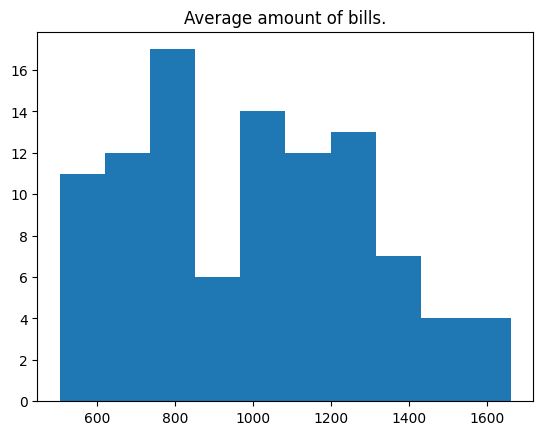

In [21]:
plot_median_bills(simulation_1_180)

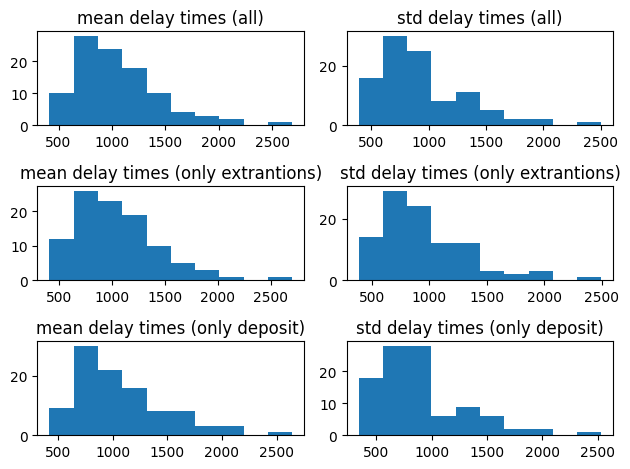

In [22]:
plot_delay_times(simulation_1_180)

In [36]:
print("Fallas de extraccion:")
extraction_failure_info(simulation_1_180)
print("Proporcion de simulaciones donde se acepta: ", proportion_of_successful_extractions(simulation_1_180))

Fallas de extraccion:
Max =  0.159779614 Min =  0.0 Median =  0.0165823435 std =  0.046202592805964726
Proporcion de simulaciones donde se acepta:  1.0


#### Simulación de arribos 1/90 (otro grupo)

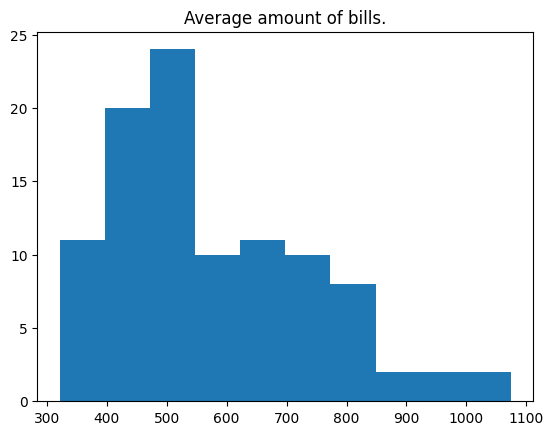

In [24]:
plot_median_bills(simulation_1_90)

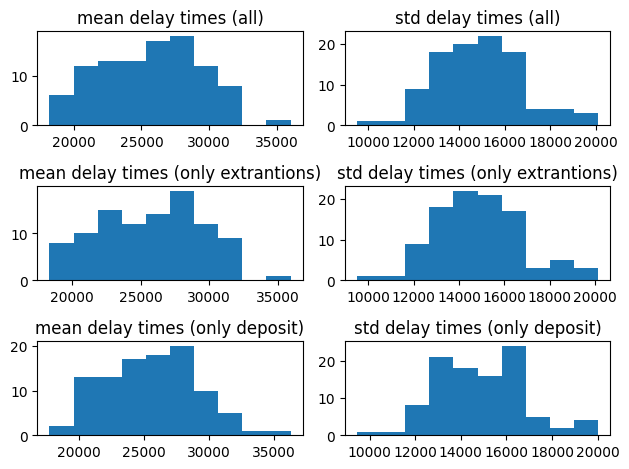

In [25]:
plot_delay_times(simulation_1_90)

In [37]:
print("Fallas de extraccion:")
extraction_failure_info(simulation_1_90)
print("Proporcion de simulaciones donde se acepta: ", proportion_of_successful_extractions(simulation_1_90))

Fallas de extraccion:
Max =  0.261096606 Min =  0.0 Median =  0.140730717 std =  0.048508291759874304
Proporcion de simulaciones donde se acepta:  0.99


### Comparativa con otro grupo

Se asignó la comparativa con el grupo 1, el cual en vez de simular con simpy utilizaron el método Montecarlo, para la misma simulación.

#### Comparativa 1/180

##### Cantidad media de billetes

Se puede apreciar una mayor concentración que en nuestra simulación, además de un incremento importante, ya que en su mayoría están por encima de los 600 billetes de media por operación.

##### Tiempos de demora

El desvío es casi idéntico en ambas simulaciones.
Donde hay diferencia es en la media de tiempos donde se ve que es mayor en ciertos días simulados (el del otro grupo), aunque este incremento es de poco menos que 500 segundos, es apreciable.
Pero en los tiempos medios de depósito no se aprecia tanto, teniendo un leve desplazamiento de casi 200 segundos de media por lo que la mayor parte del tiempo desplazado es por las operaciones de extracción, que no solo tienen una ponderación de casi el 75% si no que los tiempos medios son mayores.

A pesar de esto sigue aproximadamente la forma de nuestra simulación.

##### Rechazo de máquinas

No hay rechazo en ninguna de las simulaciones diarias del otro equipo al igual que en nuestra simulación.

##### Información de fallas de extracción

Al igual que en nuestra simulación, existen días donde no hay fallas de extracción.
Donde difiere y mucho es en el máximo y media donde en nuestra simulación es (respectivamente) $\approx 0.226$ y $\approx 0.056$ mientras que en la simulación del otro grupo es de $\approx 0.160$ y $\approx 0.0166$ (máximo y media respectivamente), una gran diferencia, casi dos tercios de nuestra proporción.
En el desvío vemos más o menos la misma diferencia entre el nuestro y del otro grupo (respectivamente) $\approx 0.060$ y $\approx 0.046$.

#### Comparativa 1/90

##### Cantidad media de billetes

Aquí se nota mucho la diferencia, donde nuestra simulación parecía una función $1/x$ con su mayoría en menos que 600 agrupándose en casi 200, la del otro grupo se agrupa su mayoría entre 400 y 500, pero se ve muy claramente un menor desvío ya que nuestra simulación llegaba a valores mucho más grandes en algunos casos.

##### Tiempos de demora

En los tiempos medios se nota un desplazamiento de casi el doble (en la simulación del otro grupo), no sólo en las extracciones sino en todas las operaciones. Como habíamos establecido antes los tiempos de operación en esta sección se ven opacados por los tiempos de espera, por lo que la demora del otro grupo es casi el doble y su desviación es de aproximadamente 1.5 veces mayor.

En este caso la forma de nuestra simulación no es tan parecida a la del otro grupo.

##### Rechazo de máquinas

Existe un 0.99 casos exitosos y ya que sólo se hicieron 100 simulaciones diarias, significa que un día simulado fracasó en la proporción de fallas de operaciones de extracción con más de 25%.

##### Información de fallas de extracción

Estos resultados son curiosos, ya que en la comparativa de arribos 1/180 los resultados del otro grupo en proporción de fallas de operaciones de extracción fue mejor con diferencia de dos tercios a la nuestra.
Pero en esta es todo lo contrario.

No vemos el mínimo porque existe (en ambas simulaciones), al menos un día simulado donde no hay errores de extracción.

El desvío se mantiene sin cambios (casi), nuestro: $\approx 0.062$; otro grupo: $\approx 0.049$.
Pero el máximo (nuestro: $\approx 0.248$; otro grupo: $\approx 0.261$) y la mediana (nuestro: $\approx 0.088$; otro grupo: $\approx 0.141$) se elevaron mucho más rápido que en nuestra simulación.
Donde nos superaban en dos tercios en la mediana ahora nuestra simulación lo supera la misma proporción.
En caso del máximo ya vimos que sólo una simulación diaria superaba el 0.25, aun así se puede ver que a diferencia de nuestra simulación, la del otro grupo incrementa la tasa de fallos mucho más rápido que la nuestra al aumentar los arribos.